<a href="https://colab.research.google.com/github/kimwoonggon/publicservant_AI/blob/master/%EC%8B%AC%ED%99%942_%ED%8A%B8%EB%9E%9C%EC%8A%A4%ED%8F%AC%EB%A8%B8_%EC%89%BD%EA%B2%8C%EA%B5%AC%ED%98%84%ED%95%B4%EB%B3%B4%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 언어 이해를 위한 트랜스포머 모델

트랜스포머를 로우레벨부터 구현해보도록 하겠습니다.  
트랜스포머를 한층 한층 직접 쌓아보이시면 추후에 트랜스포머 계열들을 쉽게 이해하실 수 있습니다.

https://www.tensorflow.org/tutorials/text/transformer 를 쉽게 구현하고 이해할 수 있도록 코드를 약간 수정하였습니다.  

직관적인 설명은 이 사이트에 더 잘 되어 있으며, 저는 직접 실행해보는 관점에서 설명드리고자 합니다. 시각적 설명을 원하시면 이 사이트에 접속하시기 바랍니다.
http://jalammar.github.io/illustrated-transformer/  


![Imgur](https://i.imgur.com/Z0QOeAG.png)

# 데이터 셋 소개

AI허브의 일상생활 및 구어체 한-영 번역 병렬 말뭉치 데이터


https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=71265

# 데이터 로드
데이터 로드는 tensorflow 2에서 제공하는 tf.data.dataset 형식으로 로드하도록 하겠습니다. dataset 형식으로 데이터를 불러오면, 향후 모델을 훈련시킬 때 @tf.function 데코레이터를 활용하여 상당히 빠르게 학습할 수 있습니다.

In [30]:
# !pip install git+https://github.com/SKT-AI/KoBART#egg=kobart
!pip install gdrive_dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
from gdrivedataset import loader
file_id = '199cATqcLjJlCTnwTY36s6NA9mAE72jRJ'
loader.load_from_google_drive(file_id)

BadZipFile: ignored

In [ ]:
# 로컬 GPU 사용할 경우
"""
import os
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

"""

In [ ]:
# 분석에 필요한 모듈 임포트
import tensorflow_datasets as tfds
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

c:\Users\USER\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# 데이터 불러오기
en_train = []
en_test = []
en_val =[]

ko_train = []
ko_test = []
ko_val =[]
dic = {'en_train':en_train, 'en_test':en_test, 'en_val':en_val, 'ko_train':ko_train, 'ko_test':ko_test, 'ko_val':ko_val}

# datasets 폴더로 부터 모든 세트파일을 읽어 '\r\n'을 제거하고 해당하는 리스트에 저장합니다.
for fname in dic.keys():
    f = open("./datasets/" + fname + ".txt", "r", encoding='UTF-8')
    while True:
        line = f.readline().strip()
        if not line: break
        dic.get(fname).append(line)
    f.close()

In [ ]:
# 리스트를 텐서플로우 데이터셋으로 변경시켜주는 함수입니다.
# 텐서플로우에서 제공하는 데이터셋은 훈련 시에 배치와 같은 편의 기능을 제공합니다.
# 아래 코드에서 from_tensor_slices 통해 만들어지는 Dataset 클래스는 영어와 한국어 데이터 셋 2개를 리턴합니다.
train_datasets = tf.data.Dataset.from_tensor_slices((en_train, ko_train))
test_datasets = tf.data.Dataset.from_tensor_slices((en_test, ko_test))
val_datasets = tf.data.Dataset.from_tensor_slices((en_val, ko_val))

In [ ]:
# 프린트해보면 2개의 텐서플로우 리스트를 갖고 있는 것을 볼 수 있습니다.
train_datasets

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [ ]:
# 샘플로 데이터를 출력해 보겠습니다.
# 바로 take() 함수를 호출하여 불러올 값을 가져올 수도 있습니다.
# Dataset 클래스는 batch() 함수를 제공합니다. 매개변수 값으로 배치 값을 받습니다.
for en_examples, ko_examples in train_datasets.batch(3).take(1):
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

  print()

  for ko in ko_examples.numpy():
    print(ko.decode('utf-8'))

I'm glad to hear that, and I hope you do consider doing business with us.
I'm definitely thinking about it, but I have some queries to ask you.
In today's world, one in every five families has either a cat, dog, or both.

그 말을 들으니 기쁘고, 저희와 거래하는 것을 고려해 주셨으면 합니다.
확실히 생각하고 있습니다만, 몇 가지 여쭤보고 싶은 게 있어요.
오늘날 세계 5가구 중 1가구는 고양이나 개 또는 둘 다를 키우고 있습니다.


# 토크나이즈

데이터셋은 준비되었으니 이제 학습에 사용될 수 있게 각 문장을 토크나이징 하겠습니다.

In [ ]:
# 한국어 토크나이저 도구 가져오기
# 한국어에 경우 영어권 언어와 다르게 subword로 분리하기 어렵습니다. 그렇기에 한국어에 특화된 도구를 필요합니다.
# kobart는 SKT에서 만든 한국어 토크나이저 도구입니다. 3만개의 vocabulary가 이미 학습되어 있습니다.
from kobart import get_kobart_tokenizer

ko_tokenizer = get_kobart_tokenizer()

using cached model. c:\Users\USER\Desktop\기말과제\.cache\kobart_base_tokenizer_cased_cf74400bce.zip


In [ ]:
# 영어에 경우는 Tensorflow에서 제공하는 토크나이저 생성 함수가 있습니다.
# 데이터셋으로부터 영어 단어만 추출해서, 단어들마다 인덱싱을 부여합니다.
# 인덱싱을 부여하는 클래스가 en_tokenizer 입니다.
en_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for en, ko in train_datasets), target_vocab_size=2**13)


INFO:absl:SubwordTextEncoder build: trying min_token_count 204849
INFO:absl:SubwordTextEncoder build: trying min_token_count 102424
INFO:absl:SubwordTextEncoder build: trying min_token_count 51212
INFO:absl:SubwordTextEncoder build: trying min_token_count 25606
INFO:absl:SubwordTextEncoder build: trying min_token_count 12803
INFO:absl:SubwordTextEncoder build: trying min_token_count 6401
INFO:absl:SubwordTextEncoder build: trying min_token_count 3200
INFO:absl:SubwordTextEncoder build: trying min_token_count 1600
INFO:absl:SubwordTextEncoder build: trying min_token_count 800
INFO:absl:SubwordTextEncoder build: trying min_token_count 400
INFO:absl:SubwordTextEncoder build: trying min_token_count 200
INFO:absl:SubwordTextEncoder build: trying min_token_count 100
INFO:absl:SubwordTextEncoder build: trying min_token_count 50
INFO:absl:SubwordTextEncoder build: trying min_token_count 75
INFO:absl:SubwordTextEncoder build: trying min_token_count 87
INFO:absl:SubwordTextEncoder build: trying 

In [ ]:
# 토크나이저로부터 vocab에 저장된 단어수를 확인해 보겠습니다.
# 한글에 경우는 이미 학습되어진 vocab을 확인할 수 있습니다.
print("영어 단어 수: %d" %en_tokenizer.vocab_size)
print("한글 단어 수: %d" %ko_tokenizer.vocab_size)

영어 단어 수: 8214
한글 단어 수: 30000


In [ ]:
# 문자열을 인코딩 해보겠습니다.
print(en_tokenizer.encode("Hello, Let's run transformer!"))
print(ko_tokenizer.encode("안녕하세요. 번역기를 돌려보아요!"))

[134, 1, 534, 7997, 11, 911, 7383, 319, 7991]
[27616, 25161, 20176, 14241, 17586, 10884, 11696, 11900, 232]


In [ ]:
# 문장마다 인코딩 시에 시작단어와 끝 단어를 의미하는 숫자를 붙입니다.

def encode(lang1, lang2):
  
  lang1 = [en_tokenizer.vocab_size] + en_tokenizer.encode(
      lang1.numpy()) + [en_tokenizer.vocab_size+1]

  lang2 = [ko_tokenizer.vocab_size] + ko_tokenizer.encode(lang2.numpy().decode('utf-8')) + [ko_tokenizer.vocab_size+1]
  return lang1, lang2

"""
lang1에는 영어 문장, lang2에는 한국어 문장을 받아서 위에서 만든 토크나이저로 토크나이징을 합니다.

다만, 모델 자체에 이를 넣어주기 위해선 Dataset.map으로 이를 콜백함수로 포함시켜야 하는데, 이로써는 불가능합니다.
Dataset.map으로 넣어줄 것은 텐서플로우 객체 및 함수 뿐이기 때문이죠.

그렇기에 이를 텐서플로우 함수로 wrapping해줘야 합니다.
"""

'\nlang1에는 영어 문장, lang2에는 한국어 문장을 받아서 위에서 만든 토크나이저로 토크나이징을 합니다.\n\n다만, 모델 자체에 이를 넣어주기 위해선 Dataset.map으로 이를 콜백함수로 포함시켜야 하는데, 이로써는 불가능합니다.\nDataset.map으로 넣어줄 것은 텐서플로우 객체 및 함수 뿐이기 때문이죠.\n\n그렇기에 이를 텐서플로우 함수로 wrapping해줘야 합니다.\n'

In [ ]:
lang1 = tf.constant("Hello man, Let's run transformer!", dtype=tf.string)
lang2 = tf.constant("안녕하세요. 번역기를 돌려보아요!", dtype=tf.string)

In [ ]:
print(encode(lang1, lang2))

([8214, 1062, 1308, 1, 534, 7997, 11, 911, 7383, 319, 7991, 8215], [30000, 27616, 25161, 20176, 14241, 17586, 10884, 11696, 11900, 232, 30001])


In [ ]:
"""
이 함수를 데이터셋의 각 요소에 적용하려면 Dataset.map을 사용합니다. Dataset.map은 그래프 모드에서 실행됩니다.
- 그래프 텐서는 값을 가지지 않습니다.
- 그래프 모드에서는 텐서플로우의 operations와 함수만을 사용할 수 있습니다.

따라서 이 함수를 직접 .map할 수 없습니다. tf.py_function으로 감싸야 합니다. tf.py_function은 감싼 Python 함수에 일반 텐서를 전달해 이를 통해 값을 사용하고 .numpy() 메서드로 액세스할 수 있도록 해줍니다.

tf.py_function을 활용하여 모든 문장에 숫자를 부여하고
인풋 값으로 en과 ko가 한문장 한문장씩 들어가서 result_en, result_ko을 아웃풋으로 내게 됨
"""

def tf_encode(en, ko):
  result_en, result_ko = tf.py_function(encode, [en, ko], [tf.int64, tf.int64])
  result_en.set_shape([None])
  result_ko.set_shape([None])
  return result_en, result_ko

In [ ]:
# 전체 데이터에서 x가 영어 한 문장, y가 한글 한 문장인데
# 만약 문장이 인코딩 되었을 때, 인코딩 된 길이가 40을 초과하면 데이터에서 배제하고자 하는 필터 함수임

MAX_LENGTH = 40

def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [ ]:
# 이제 Datasets의 편의기능을 통해 전처리에 필요한 함수들을 맵핑하겠습니다.

BUFFER_SIZE = 600000
BATCH_SIZE = 64


train_dataset = train_datasets.map(tf_encode) # tf_encode 함수를 활용해서 영어, 한국어 각 문장에 시작 토큰과 끝 토큰을 부여함
train_dataset = train_dataset.filter(filter_max_length) # 문장의 길이가 40이 넘는 문장은 배제하고자 함
train_dataset = train_dataset.cache() # cache를 활용해서 데이터를 로드할 때 빠른 처리를 기대해 봄
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE) 
"""
shuffle(600000) 인데, 이 말은 전체 데이터를 완전히 섞겠다는 뜻입니다.
전체 데이터의 수가 500000인데 500000보다 큰 숫자를 입력하면 완전하게 전체 데이터를 섞는 것이며
전체 데이터 수보다 작은 수를 입력하면 전체 데이터에서 일부만 섞게 됩니다.
padded_batch는 이번 데이터셋은 문장마다 길이가 모두 다르기에 배치 사이즈(64) 만큼의 문장을 뽑을 때마다
배치 사이즈에 해당하는 만큼의 문장의 길이는 일정하게 유지됩니다.
만약 배치가 2개라면 이 중 하나의 문장의 길이는 37이 될 수 있고
두 개의 배치(64) 중 하나의 배치는 문장의 길이를 37개로 모두 유지
그 다음 배치에서 문장의 길이가 39 라면, 그 배치에서는 문장의 길이를 39로 유지
"""

                                                                            
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE) # 데이터 로드와 처리의 시간을 overlap하여 속도를 향상 시킵니다.

val_dataset = val_datasets.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE) #가변길이의 배치를 돌릴때 반드시 사용합니다.

# 트랜스포머 구조

![Imgur](https://i.imgur.com/Tl2zsFL.png)

트랜스포머의 구조는
1. (위치 + 단어 임베딩)
2. 인코더
3. 디코더로 나뉩니다.





먼저 임베딩부터 살펴보도록 하겠습니다.


# 임베딩 파트 정의
해당 예시에서 트렌스포머 모델은 순회나 컨볼루션을 포함하고 있지 않기 때문에
문장에서 단어의 상대적 위치에 대한 정보를 모델에게 제공하기 위해 포지셔널 인코딩이 추가됩니다.

즉, 트랜스포머의 어텐션 레이어는 인풋을 순서 없는 벡터 세트로 봅니다.
이에 각 단어의 임베딩 벡터의 위치정보를 더하여 인풋으로 활용합니다.
단어 임베딩 + 위치 임베딩, 두 가지 임베딩을 거치게 됩니다.

**위치 임베딩을 하는 이유는 RNN 계열 같이 문장 내부 단어의 순서를 나타낼 방법이 없기 때문입니다.**  
같은 단어라도 위치 임베딩 때문에 순서에 따라서 단어가 임베딩 된 것은 다를 수 있습니다.
![Imgur](https://i.imgur.com/sSnVRpY.png)

![Imgur](https://i.imgur.com/SNIEhlA.png)

In [ ]:
# 먼저 포지셔널 임베딩부터
# pos / 10000 ** (2i / d_model)에 해당하는 부분을
# get_angles 함수로 출력하기

def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i // 2) / np.float32(d_model)))
    # shape = (1, d_model)
  return np.matmul(pos, angle_rates) # pos shape : (pos, 1), angle_rates shape = (1, d_model),
                                     # np.matmul(pos, angle_rates) shape : 행렬곱 (pos,1), (1, d_model) = (pos, d_model)

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model) # shape : (position, d_model)
  # 오른쪽으로 짝수번째 인덱스는 sin 함수를 적용
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  # 오른쪽으로 홀수번째 인덱스는 cos 함수를 적용
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...] # pos_encoding shape : (1, position, d_model)
                                             # 왜 shape에 1을 추가해주냐면, batch_size 만큼 학습하기 위함임

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


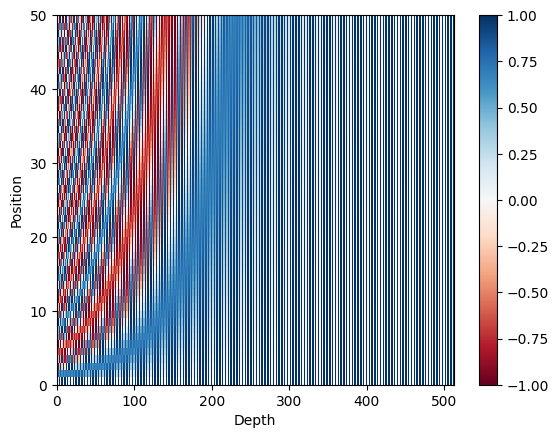

In [ ]:
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel("Depth")
plt.xlim((0, 512))
plt.ylabel("Position")
plt.colorbar()
plt.show()

단어 임베딩 + 포지셔널 임베딩 클래스 구현  
주의할 점은 포지셔널 단어임베딩 * sqrt(임베딩 차원), 즉 루트가 곱해져야함  
위치 임베딩은 단순히 위치만 나타내기 때문에, 가중치가 단어 임베딩보단 적어야 신경망이 잘 학습됨

In [ ]:
class TransformerEmbedding(tf.keras.layers.Layer):
  def __init__(self, d_model, input_vocab_size, maximum_position_encoding, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model # 하나의 단어가 d_model의 차원으로 인코딩 됨
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
     # vocab_size는 tokenizer 내부 vocab.txt의 사이즈
    self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model) # 포지셔널 인코딩
    self.dropout = tf.keras.layers.Dropout(dropout_rate) # 드롭아웃 설정
    

  def call(self, x, training):
    # 최초 x의 shape = (batch_size, seq_len)
    seq_len = tf.shape(x)[1]
    out = self.embedding(x) # shape : (batch_size, input_seq_len, d_model)
    out = out * tf.math.sqrt(tf.cast(self.d_model, tf.float32)) # x에 sqrt(d_model) 만큼을 곱해주냐면, 임베딩 벡터보다 포지셔널 인코딩 임베딩 벡터의 영향력을 줄이기 위해서임
                                                            # 포지셔널 인코딩은 순서만을 의미하기 때문에 임베딩 벡터보다 영향력이 적어야 이치에 맞음
    out = out + self.pos_encoding[:,:seq_len,:]
    out = self.dropout(out, training=training)
    

    return out # shape : (batch_size, input_seq_len, d_model)

In [ ]:
x = np.float32(np.random.uniform(size=(1,40))) # 문장 길이 40
Embedder = TransformerEmbedding(512, ko_tokenizer.vocab_size+2, 10000)
embedded = Embedder(x, False)
print(embedded) # 문장이 위치 임베딩 + 포지션 임베딩

tf.Tensor(
[[[-0.5601563   1.5322415   0.01263841 ...  1.4455402   0.18948928
    1.026099  ]
  [ 0.28131467  1.0725437   0.8344946  ...  1.4455402   0.18959294
    1.026099  ]
  [ 0.34914112  0.11609462  0.9490531  ...  1.4455402   0.1896966
    1.026099  ]
  ...
  [-1.2036943   1.2976556  -0.89387923 ...  1.4455322   0.1933248
    1.0260916 ]
  [-0.26378772  1.4873152  -0.85076153 ...  1.4455318   0.19342847
    1.0260912 ]
  [ 0.40363908  0.7988844  -0.06459328 ...  1.4455314   0.19353214
    1.0260907 ]]], shape=(1, 40, 512), dtype=float32)



# 스케일드 닷 프로덕트 어텐션
문장이 셀프 어텐션 되어서 어텐션 값과, 소프트맥스 함수를 출력하는 함수를 만들고자 합니다. scaled라는 의미는, 루트(단어의 차원 512)만큼 어텐션 값에서 나눠져 스케일링이 되기 때문에 스케일드 닷 프로덕트 어텐션이라는 이름이 붙여진 것입니다.  


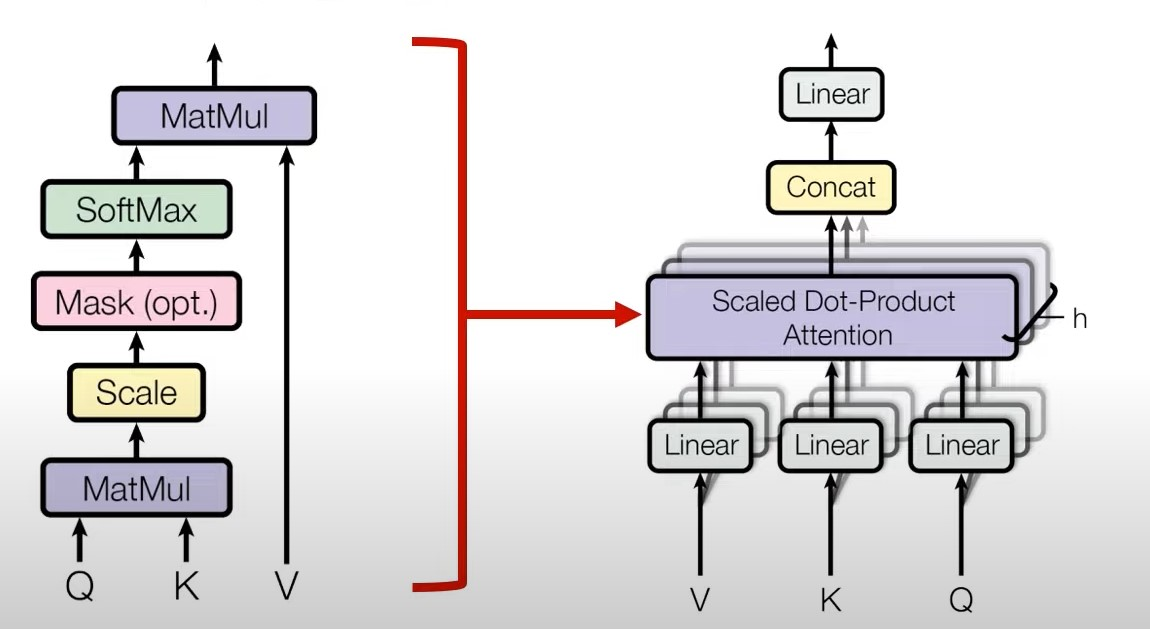

In [ ]:
from IPython.display import Image, display
display(Image(filename='img1.jpg', embed=True))

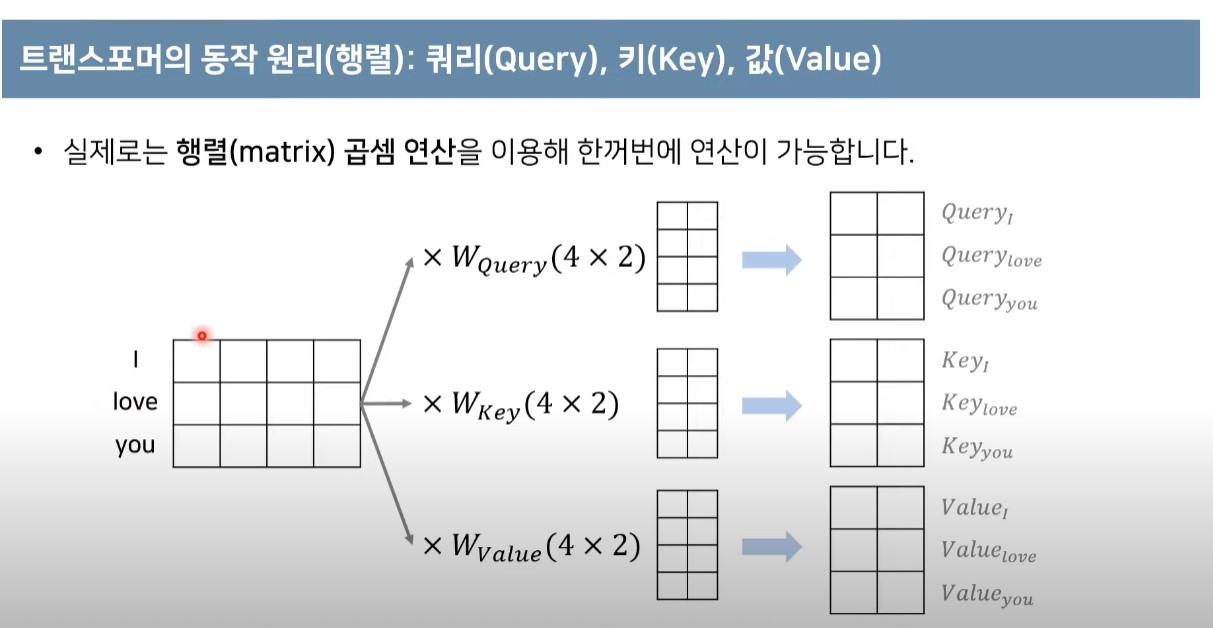

In [ ]:
display(Image(filename='img3.jpg', embed=True))

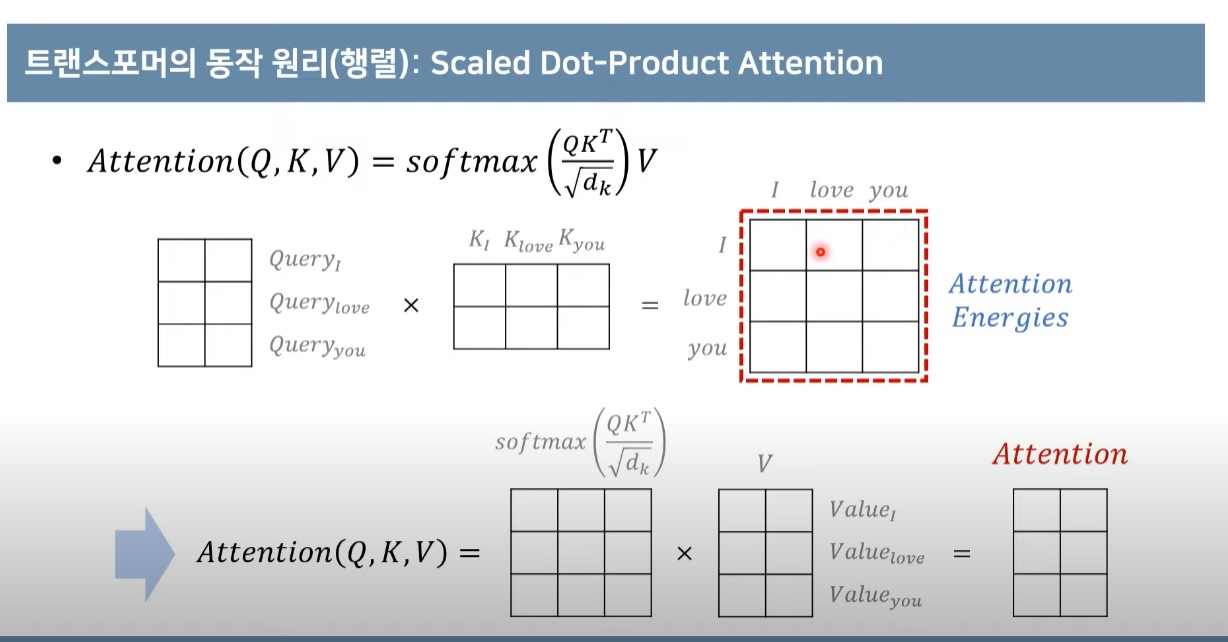

In [ ]:
display(Image(filename='img2.jpg', embed=True))

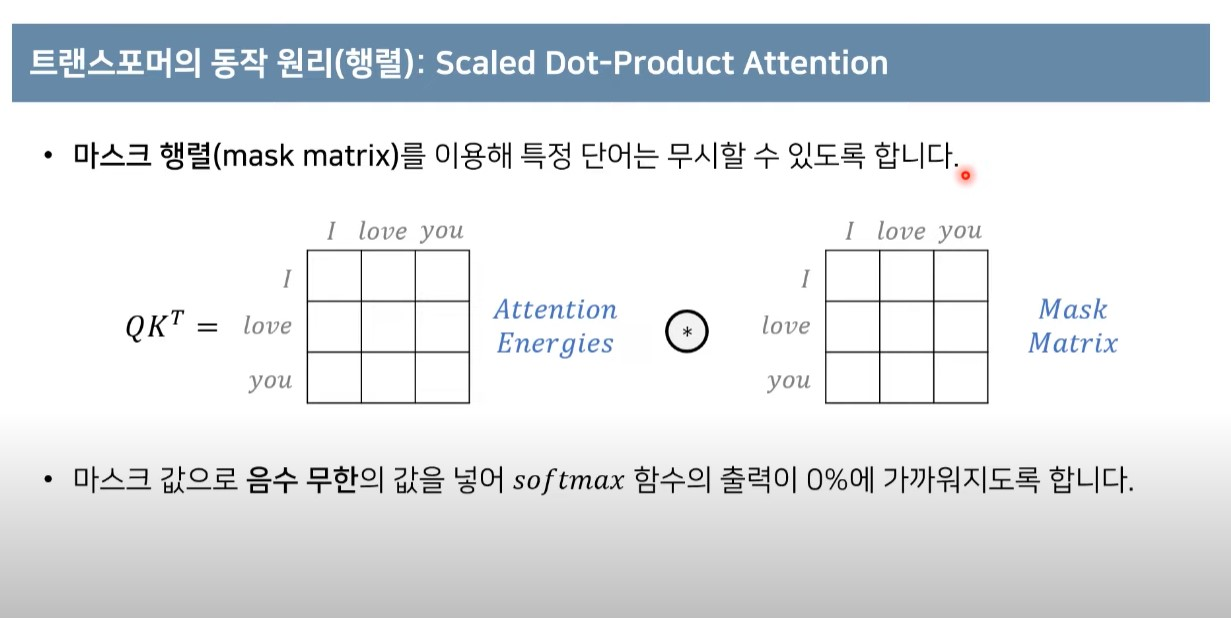

In [ ]:
display(Image(filename='img4.jpg', embed=True))

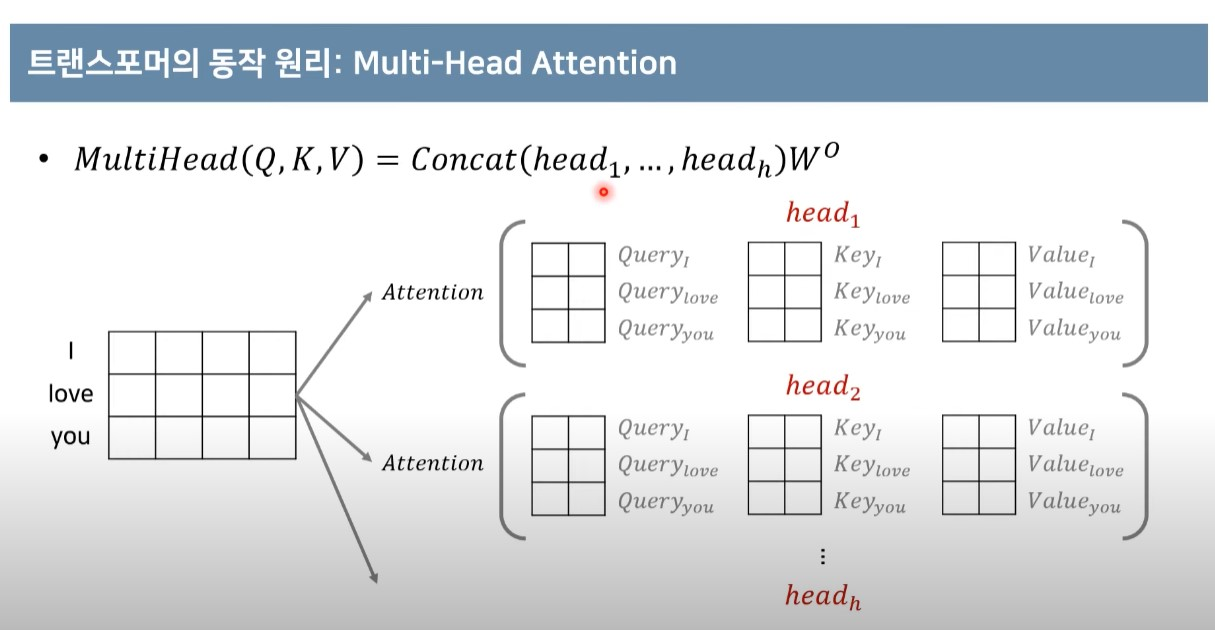

In [ ]:
display(Image(filename='img5.jpg', embed=True))



![Imgur](https://i.imgur.com/9fmQJl9.png)  
제 깃허브에 올린 **심화1_어텐션의 근본적인 이해** 에서 어텐션 부분과 다른 점이 거의 없으니 복습하시면 됩니다.  
mask를 True로 설정하면 소프트맥스 아웃풋에서, 마스크 된 부분은 0으로 바뀌게 됩니다. 왜냐면 -1e9는 상당히 큰 값인데, e^(-1e9)는 0에 수렴하기 때문입니다.  
왜 트랜스포머에 마스크가 들어가는 지는 두 가지로 말씀드리겠습니다. **1) 인풋의 길이를 신경망 학습을 위해 일정한 길이로 맞추다 보면, 원래 문장의 길이를 초과하는 만큼은 패딩이 됩니다. 그 패딩한 부분을 어텐션 연산에 참여시키지 않기 위해 마스크를 사용하는 것입니다.**  
**2) Seq2Seq같은 기계 번역을 할 때에는 인코딩 부분과 단어 일부로 다음 단어를 예측하기 때문에, 단어 전체를 훈련하지 않고 일부분만 훈련하는 것이 논리에 맞습니다. 따라서 mask로 훈련에 필요하지 않은 부분은 0으로 바꿔주게 됩니다.**


문장들이 임베딩되면 인풋의 차원은 (batch_size, seq_len, d_model)입니다.  
scaled_dot_product_attention 이후의 차원 또한 (batch_size, seq_len, d_model)입니다.  
**즉 인풋과 아웃풋의 사이즈가 동일하게 됩니다.**  

따라서 scaled_dot_product_attention의 결과는 단어들 간의 연관성을 학습한다고 이해하시면 되겠습니다.

In [ ]:
def scaled_dot_product_attention(q, k, v, mask=None):
  # q shape : (batch_size, seq_len, d_model)
  # k shape : (batch_size, seq_len, d_model)
  # v shape : (batch_size, seq_len, d_model)
  matmul_qk = tf.matmul(q, k, transpose_b = True)
  #matmul_qk shape : (batch_size, seq_len, seq_len)                                                

  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # scaled_attetion_logits shape : (batch_size, seq_len, seq_len)

  if mask is not None:
    scaled_attention_logits = scaled_attention_logits + (mask * -1e9)

  softmax = tf.nn.softmax(scaled_attention_logits, axis=-1)

  # softmax shape : (batch_size, seq_len, seq_len)

  output = tf.matmul(softmax, v)

  # output(attention_value) shape : (batch_size, seq_len, d_model)
  # 즉 처음 입력 차원인 (batch_size, seq_len, d_model) 차원을 아웃풋으로 반환

  return output, softmax

In [ ]:
q = tf.cast(np.random.uniform(size=(1,2,512)), dtype=tf.float32)
k = tf.cast(np.random.uniform(size=(1,7,512)), dtype=tf.float32)
v = tf.cast(np.random.uniform(size=(1,7,512)), dtype=tf.float32)
scaled_dot_product_attention(q,k,v)

(<tf.Tensor: shape=(1, 2, 512), dtype=float32, numpy=
 array([[[0.50889784, 0.67782605, 0.39095488, ..., 0.3642616 ,
          0.2836956 , 0.60419846],
         [0.49110797, 0.6628632 , 0.39022022, ..., 0.37625372,
          0.28921145, 0.61549425]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2, 7), dtype=float32, numpy=
 array([[[0.16216005, 0.13309817, 0.10563419, 0.13490772, 0.12748916,
          0.17091765, 0.165793  ],
         [0.17035533, 0.14263847, 0.11429396, 0.10284436, 0.12903787,
          0.16701384, 0.1738162 ]]], dtype=float32)>)

# 멀티 헤드 어텐션 정의
멀티 헤드 어텐션은 전체 어텐션을 분리하여 병렬적으로 어텐션을 수행하는 기법입니다.  
즉 (batch_size, 50, 64*8) 의 텐서가 있다면 이것을 (batch_size, 50, 64) 의 8개의 텐서로 나눈다음에 개별적으로 어텐션을 수행하고, 다시 (batch_size, 50, 64*8)의 텐서로 concat(합치는) 하게 됩니다.  
이렇게 하는 이유는, 깊은 차원을 한번에 어텐션을 수행하는 것보다, 병렬로 각각 수행하는 것이 더 심도있는 언어들간의 관계를 학습할 수 있기 때문입니다.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super().__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0,2,1,3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)
    k = self.wk(k)
    v = self.wv(v)

    q = self.split_heads(q, batch_size)
    k = self.split_heads(k, batch_size)
    v = self.split_heads(v, batch_size)


    attention_weights, softmax = scaled_dot_product_attention(q, k, v, mask)

    scaled_attention = tf.transpose(attention_weights, perm=[0,2,1,3])

    concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

    output = self.dense(concat_attention)

    return output, softmax

In [ ]:
q = tf.cast(np.random.uniform(size=(1,2,512)), dtype=tf.float32)
k = tf.cast(np.random.uniform(size=(1,7,512)), dtype=tf.float32)
v = tf.cast(np.random.uniform(size=(1,7,512)), dtype=tf.float32)
temp_mha = MultiHeadAttention(512, 8)
encoder_output, _ = temp_mha(v,k,q, mask=None)
print(encoder_output)

tf.Tensor(
[[[-0.40085423  0.05235365  0.19380227 ... -0.17250857 -0.28667095
   -0.26964194]
  [-0.41141     0.05054253  0.17369695 ... -0.1732516  -0.28654766
   -0.256213  ]]], shape=(1, 2, 512), dtype=float32)


# 포인트와이즈 피드 포워드 네트워크 정의
Pointwise Feed Forward 네트워크에서는 인코더의 출력에서 512개의 차원이 2048차원까지 확장되고,  
다시 512개의 차원으로 압축됩니다.

In [ ]:
class Pointwise_FeedForward_Network(tf.keras.layers.Layer):
  def __init__(self, d_model, dff):
    super().__init__()
    self.d_model = d_model
    self.dff = dff

    self.middle = tf.keras.layers.Dense(dff, activation='relu')
    self.out = tf.keras.layers.Dense(d_model)

  def call(self, x):
    middle = self.middle(x) # middle shape : (batch_size, seq_len, dff)
    out = self.out(middle) # out shape : (batch_size, seq_len, d_model)
    return out

In [ ]:
sample_PFFN = Pointwise_FeedForward_Network(512, 2048)
sample_PFFN(encoder_output)

<tf.Tensor: shape=(1, 2, 512), dtype=float32, numpy=
array([[[ 0.03023958,  0.13165513,  0.0968949 , ...,  0.16731931,
         -0.20068507, -0.3437758 ],
        [ 0.03384819,  0.1348396 ,  0.08575221, ...,  0.16772684,
         -0.2006481 , -0.3533344 ]]], dtype=float32)>

# 인코더, 디코더 정의
지금까지 임베딩 -> 멀티 헤드 어텐션 -> 포인트와이즈 피드 포워드 네트워크까지 살펴 보았습니다.  
트랜스포머에서의 인코딩은 (멀티헤드어텐션 + 포인트와이즈 피드 포워드 네트워크)를 층층이 쌓은 것입니다. 따라서 방금 공부했던 멀티헤드 어텐션과 포인트와이즈 피드 포워드 네트워크를 겹겹이 쌓아서, 인코더층을 쌓는 것입니다.  

인코더 레이어를 정의해서 멀티헤드 어텐션과 포인트와이즈 피드 포워드 네트워크를 합쳐 보도록 하겠습니다. 

단어 임베딩 벡터(단어 임베딩+위치 임베딩)가 -> 1. 멀티헤드어텐션  -> 2. Residual Network를 거쳐 원래 input과 멀티헤드어텐션의 합이 출력 -> 3. 포인트와이즈 피드포워드 네트워크 를 거치고, -> 4. Residual Network를 거쳐서 원래의 인풋과 포인트와이즈 피드포워드 네트워크의 합이 출력됨  
![Imgur](https://i.imgur.com/w4n19Rs.png)

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super().__init__()
    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = Pointwise_FeedForward_Network(d_model, dff)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

  def call(self, x, training, mask=None):
    # x : 위치 임베딩 + 단어 임베딩 된 인코딩의 인풋
    attn_output, _ = self.mha(x, x, x, mask) 
    # 멀티헤드 어텐션
    # attn_output shape : (batch_size, input_seq_len, d_model)

    attn_output = self.dropout1(attn_output, training=training)

    out1 = self.layernorm1(x + attn_output) # Residual Network 거침, 레이어 노멀레이제이션을 통한 값 평준화

    ffn_output = self.ffn(out1) # ffn_output_shape : (batch_size, input_seq_len, d_model), 포인트와이즈 피드포워드 네트워크
    ffn_output = self.dropout2(ffn_output, training=training)

    out2 = self.layernorm2(out1 + ffn_output)   # Residual Network 거침
                                                # out2 shape : (batch_size, input_seq_len, d_model)

    return out2

In [ ]:
# 임베딩
x = np.float32(np.random.uniform(size=(1,40))) # 문장 길이 40
Embedder = TransformerEmbedding(512, ko_tokenizer.vocab_size+2, 10000)
embedded = Embedder(x, False)
print(embedded) # 문장이 위치 임베딩 + 포지션 임베딩
#인코더
sample_encoder = EncoderLayer(d_model=512, num_heads=8, dff=2048, rate=0.1)
sample_encoding = sample_encoder(embedded, training=None, mask=None)
print(sample_encoding)
#최종출력
print("Encoded 차원 :", sample_encoding.shape)

tf.Tensor(
[[[-0.34677264  0.629176    1.0623413  ...  1.5045588   0.64450985
    1.7585243 ]
  [ 0.49469832  0.1694783   1.8841975  ...  1.5045588   0.6446135
    1.7585243 ]
  [ 0.5625248  -0.78697085  1.998756   ...  1.5045588   0.64471716
    1.7585243 ]
  ...
  [-0.9903108   0.39459008  0.15582371 ...  1.5045509   0.6483454
    1.758517  ]
  [-0.05040407  0.5842497   0.19894141 ...  1.5045505   0.64844906
    1.7585166 ]
  [ 0.61702275 -0.10418105  0.9851096  ...  1.5045501   0.6485527
    1.7585161 ]]], shape=(1, 40, 512), dtype=float32)
tf.Tensor(
[[[-0.60359734 -0.03568865  0.91060966 ...  0.6408077   1.0560235
    1.4297667 ]
  [-0.03304997 -0.32223484  1.5756514  ...  0.70899385  1.1043317
    1.4320568 ]
  [-0.07986902 -1.0041614   1.6867299  ...  0.7051732   1.0752949
    1.3969804 ]
  ...
  [-1.4814655  -0.12692298 -0.11983072 ...  0.8761788   0.8783611
    1.3302034 ]
  [-0.7655177   0.03328818 -0.02282204 ...  0.8263385   0.9148229
    1.3523204 ]
  [-0.2388491  -0.40094

디코더를 정의하도록 하겠습니다.  
![Imgur](https://i.imgur.com/kGTfPr8.png)

디코더는 인코더랑 유사하지만, 구조가 약간 다릅니다. 
이번 Seq2Seq는 한국어를 영어로 바꾸는 문제입니다.  디코더에서는 
두단계의 멀티 헤드 어텐션 구조를 거치는데, **첫번째 멀티 헤드 어텐션은**, **영어문장과 영어문장의 셀프 어텐션을 하여**, 영어 문장간의 관계를 배우게 됩니다.  
두번째 멀티 헤드 어텐션은 **한국어가 인코딩 된 것과**, **영어 문장간의 셀프** **어텐션된 결과를 다시 어텐션 해서 포르투갈 어와 영어의 관계를 학습하게 됩니다.**  

한국어가 암호화된 것과, 영어 문장 한단어 한단어를 보면서 다음 단어를 예측하게 되기 때문에, look_ahead_mask를 사용하게 됩니다.  
만약 영어 문장이 (I love you) 로 이루어져 있다면, look_ahead_mask를 사용하면,  
(I, 0, 0) -> Love 예측, (I love, 0) -> You 예측, (I love you) -> 단어의 끝인 [SEP] 예측을 합니다.   
**즉 look_ahead_mask는 다음 단어를 예측할 때, 전에 있던 단어만으로 예측할수 있도록 앞에 있는 단어는 가리는 것입니다.**
  
  이러한 역할을 가능하게 하는 mask가 look_ahead_mask 입니다.

look_ahead_mask를 알아보겠습니다.**(매우 중요)**  
참고로 패딩은 1로 하겠습니다. 왜냐하면 어텐션 부분에서 mask * (-1e9)를 하는데, 패딩이 1이어야 -1e9가 곱해져서 상당히 음수로 큰 수가 되는 것이고, 이게 소프트 맥스에 들어가면 0이 되기 때문입니다.(지수함수라 지수함수에 -음수는 0으로 수렴)  
![Imgur](https://i.imgur.com/eLAlzji.png)  
![Imgur](https://i.imgur.com/gAVenk0.png)  
![Imgur](https://i.imgur.com/hsZ6dGs.png)

In [ ]:
# 상삼각행렬 만들기
tf.linalg.band_part(tf.ones((10, 10)), -1, 0)

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)>

In [ ]:
temp_mask = 1 - tf.linalg.band_part(tf.ones((40, 40)), -1, 0)
print(temp_mask)

tf.Tensor(
[[0. 1. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(40, 40), dtype=float32)


In [ ]:
# 예제 문장 (1, 40) 즉, 1문장, 40개의 단어를 가짐
example_sentence = np.hstack([np.random.randint(20, size=10), np.zeros(30)])[np.newaxis, :]
print(example_sentence) # 예제 문장
example_sentence = tf.cast(tf.math.equal(example_sentence, 0), dtype=tf.float32)
print(example_sentence) # 패딩 된 것(문장에서 0이 아닌 부분은 0으로, 0인 부분은 1로)
example_sentence = example_sentence[:, tf.newaxis, tf.newaxis, :] # 차원 변경
print(example_sentence)

look_ahead_mask = tf.maximum(temp_mask, example_sentence) # 상삼각행렬과 example sentence를 비교해가며 최대값만 취해서 패딩을 1로 처리함
# look ahead mask
print(look_ahead_mask)

[[16.  8. 15. 15.  8.  7. 10.  5. 13.  8.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]]
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]], shape=(1, 40), dtype=float32)
tf.Tensor(
[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
    1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]]], shape=(1, 1, 1, 40), dtype=float32)
tf.Tensor(
[[[[0. 1. 1. ... 1. 1. 1.]
   [0. 0. 1. ... 1. 1. 1.]
   [0. 0. 0. ... 1. 1. 1.]
   ...
   [0. 0. 0. ... 1. 1. 1.]
   [0. 0. 0. ... 1. 1. 1.]
   [0. 0. 0. ... 1. 1. 1.]]]], shape=(1, 1, 40, 40), dtype=float32)


In [ ]:
# look_ahead_mask 알아보기
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask
  
def create_masks(tar):
  temp_mask = create_look_ahead_mask(tf.shape(tar)[1])
  
  
  reverse_tar = tf.cast(tf.math.equal(tar, 0), dtype=tf.float32)
  reverse_tar = reverse_tar[:,tf.newaxis,tf.newaxis,:]
  look_ahead_mask = tf.maximum(reverse_tar, temp_mask)


  return look_ahead_mask

또한 패딩 마스크를 두어서, 패딩인 부분은 1으로 처리하겠습니다.

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
example_sentence = np.hstack([np.random.randint(20, size=10), np.zeros(30)])[np.newaxis, :]
# 패딩 되기 전
print(example_sentence)
# 패딩 된 후
print(create_padding_mask(example_sentence))

[[17.  4.  4. 10. 10. 14. 12.  8.  3. 16.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]]
tf.Tensor(
[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
    1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]]], shape=(1, 1, 1, 40), dtype=float32)


In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super().__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)
    
    self.ffn = Pointwise_FeedForward_Network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)


  def call(self, x, enc_output, training, padding_mask, look_ahead_mask):
    # x : 훈련 과정에서는 Seq2Seq에서 번역이 될 문장이 입력됨,
    # x : 추론 과정에서는 과거의 단어가 입력됨
    # enc_output : 인코더의 출력
    # padding_mask : 멀티 헤드 어텐션에 필요한 정보만 남기고 나머지는 패딩 처리
    # look_ahead_mask : 위에 설명
    # enc_output_shape == (batch_size, input_seq_len, d_model)

    #### 첫번째 멀티 헤드 어텐션 파트임 ####
    #### 첫번째 멀티 헤드 어텐션은, 인코더와의 결합 없이 번역이 될 문장끼리만 어텐션을 함 ####
    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
    out1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(out1 + x)
    
    #### 두번째 멀티 헤드 어텐션 파트임 ####
    #### 두번째 멀티 헤드 어텐션 파트는 enc_output에서 인코더와(한국어), out1(영어문장으로만 셀프어텐션을 한 것)
    #### 이 다시 멀티 헤드 어텐션 과정을 거치게 됨
    #### 다시 상기하자면, 이번 과제는 포르투갈 어를 영어로 번역하는 것임
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)
    out2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(out2 + out1) # (batch_size, target_seq_len, d_model)
    

    ffn_output = self.ffn(out2)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2) # (batch_size, target_seq_len, d_model)
    

    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)
sample_decoder_layer_output, _, _ = sample_decoder_layer(embedded, sample_encoding, False, None, None)
print(sample_decoder_layer_output)
print(sample_decoder_layer_output.shape)

tf.Tensor(
[[[-1.0776527  -0.3179263  -1.3895528  ...  0.49999386  0.9215568
    0.19371346]
  [-0.6946075  -0.57536316 -0.9718574  ...  0.51007825  0.8941099
    0.21581554]
  [-0.62622625 -1.0533098  -0.9380343  ...  0.57359356  0.85566574
    0.26002917]
  ...
  [-1.4291295  -0.37418875 -1.603538   ...  0.5513199   0.7774836
    0.37017298]
  [-0.973752   -0.23389454 -1.6506991  ...  0.5119595   0.83530104
    0.33883414]
  [-0.65146095 -0.5166128  -1.3332144  ...  0.52138674  0.9287863
    0.3340962 ]]], shape=(1, 40, 512), dtype=float32)
(1, 40, 512)


이제 여러 층의 인코더를 쌓는 Encoder Class를 정의해보도록 하겠습니다.

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)] # 인코더를 쌓아서 층을 만듦


  def call(self, x, training, mask):
    # 인풋은 타겟 임베딩 + 포지셔닝 임베딩
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x # 출력 모양 : (batch_size, input_seq_len, d_model), 인코더의 층을 출력으로 내보냄

In [ ]:
Encoder_layer = Encoder(6, 512, 8, 2048) #6층, 512차원의 단어 임베딩, 8개의 병렬 멀티 헤드 어텐션의 인코더
# embedded : 위치 임베딩 + 단어 임베딩
Encoded = Encoder_layer(embedded, False, None)
print(Encoded, Encoded.shape)

tf.Tensor(
[[[-0.07255623  0.8420226  -0.6684799  ... -0.55836767  0.58508354
   -0.03397229]
  [-0.03510869  0.81003594 -0.6181954  ... -0.5321961   0.58436066
   -0.06093389]
  [-0.04808627  0.77333647 -0.586295   ... -0.5120863   0.5698679
   -0.07702167]
  ...
  [-0.18353234  0.83646095 -0.64002496 ... -0.5550337   0.48042616
    0.04108152]
  [-0.06023221  0.84178185 -0.6372025  ... -0.55592537  0.47388366
    0.03241998]
  [ 0.04752304  0.80090123 -0.5836937  ... -0.55654806  0.46309882
    0.02294975]]], shape=(1, 40, 512), dtype=float32) (1, 40, 512)


In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]


  def call(self, x, enc_output, training, padding_mask, look_ahead_mask):
    attention_weights = {}

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training, padding_mask, look_ahead_mask)

      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

    return x, attention_weights

In [ ]:
# 위치 임베딩 + 포지셔널 임베딩
embedded
#인코더 아웃풋 
Encoded

# 디코더의 위치+포지셔널 임베딩(Teaching Force 과정이라 디코더 부분에 타겟(영어)도 넣어줌)
target_embedder = TransformerEmbedding(d_model=512, input_vocab_size=ko_tokenizer.vocab_size, maximum_position_encoding=512, dropout_rate=0.1)
target_embedding = target_embedder(tf.cast(np.random.uniform(size=(1,40)), dtype=tf.float32), True)

# 6층 디코더
Decoder_layer = Decoder(num_layers=6, d_model=512, num_heads=8, dff=2048)

Decoded, _ = Decoder_layer(target_embedding, Encoded, False, None, None) # Decoded에서 인코더와 디코더의 정보 결합
print(Decoded, Decoded.shape)
#최종출력
print("6층 Decoder 출력 :", sample_encoding.shape)

tf.Tensor(
[[[ 0.5089959  -0.37852675  0.54751015 ... -0.7041627  -0.2570537
    0.27281553]
  [ 0.51725477 -0.38029277  0.54672265 ... -0.7202099  -0.25725543
    0.29542527]
  [ 0.52808326 -0.3930191   0.5551009  ... -0.7009022  -0.25583965
    0.28066197]
  ...
  [ 0.49959356 -0.3721109   0.5503463  ... -0.70051134 -0.24616654
    0.28254747]
  [ 0.51119846 -0.37088633  0.56024474 ... -0.6981992  -0.2313579
    0.30492193]
  [ 0.5238231  -0.37105003  0.5598578  ... -0.69479996 -0.23958902
    0.29990673]]], shape=(1, 40, 512), dtype=float32) (1, 40, 512)
6층 Decoder 출력 : (1, 40, 512)


# 임베딩 + 인코딩 + 디코딩을 결합하는 Transformer Class 정의  
최종적으로 지금까지 배웠던 임베딩, 인코딩, 디코딩을 결합하는 Transformer Class를 정의하겠습니다.

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
    
    # num_layers : 인코딩, 디코딩을 몇 층으로 할 지
    # d_model : 임베딩의 차원
    # num_heads : 병렬로 어텐션을 수행할 멀티 헤드 어텐션의 개수
    # dff : 포인트와이즈 피드포워드 네트워크에서 몇 차원의 연산이 이루어 질 지
    # input_vocab_size : 본 문제는 한국어를 영어로 번역하는 문제이며, 한국어 토크나이저의 총 단어수를 뜻함(처음 도입부에서 만들었음)
    # target_vocab_size : 영어 토크나이저의 총 단어수를 뜻함(위와 마찬가지)
    # pe_input : 별로 중요한 것은 아니지만, 위치 임베딩 할 때 위치 임베딩의 길이의 상한을 뜻함(영어)
    # pe_target : 위치 임베딩의 상한(한국어)
    super().__init__()
    
    self.input_embedder = TransformerEmbedding(d_model, input_vocab_size, pe_input, rate) # 영어 임베딩
    self.encoder = Encoder(num_layers, d_model, num_heads, dff, rate) # x층 인코더

    self.target_embedder = TransformerEmbedding(d_model, target_vocab_size, pe_target, rate) # 한국어 임베딩
    self.decoder = Decoder(num_layers, d_model, num_heads, dff, rate) # x층 디코더

    self.final_layer = tf.keras.layers.Dense(target_vocab_size) # 최종 출력 decoder (한국어 단어의 수), 우리가 맞추려는 것은 한국어 단어의 인덱스이므로..

  def call(self, inp, tar, training):
    # inp : 영어
    # tar : 한국어

    
    enc_mask = create_padding_mask(inp) # 인코더 패딩
    dec_mask = create_padding_mask(inp) # 디코더 패딩
    look_ahead_mask = create_masks(tar) # 디코더에 들어갈 look_ahead_mask 정의

    inp_embedding = self.input_embedder(inp) # 인코더 임베딩 정의
    enc_output = self.encoder(inp_embedding, training, enc_mask) # 인코더 아웃풋(디코더와 결합되게 됨)

    tar_embedding = self.target_embedder(tar) # 디코더 임베딩 정의
   
    dec_output, attention_weights = self.decoder(tar_embedding, enc_output, training, dec_mask, look_ahead_mask)
    
    final_output = self.final_layer(dec_output) # 최종 영어 단어를 예측하는 아웃풋 정의

    return final_output

In [ ]:
# 트랜스포머 테스트하기
sample_transformer = Transformer(6, 512, 8, 2048, en_tokenizer.vocab_size + 2, ko_tokenizer.vocab_size + 2, 10000, 30000)
inp = tf.cast(np.random.randint(100,size=40)[np.newaxis, :], dtype=tf.int32)
tar = tf.cast(np.random.randint(100,size=40)[np.newaxis, :], dtype=tf.int32)
transformer = sample_transformer(inp, tar, False)
print(transformer)

tf.Tensor(
[[[ 0.1354033  -0.03957384 -0.10251021 ...  0.10373113  0.03576743
    0.2077394 ]
  [ 0.12709835 -0.03989911 -0.10430301 ...  0.10005516  0.03007436
    0.19249678]
  [ 0.11885595 -0.04332529 -0.11877966 ...  0.09237966  0.02896868
    0.20056763]
  ...
  [ 0.1078611  -0.03748939 -0.12433676 ...  0.05418177  0.03254477
    0.18000685]
  [ 0.10565607 -0.03166128 -0.11901712 ...  0.05905444  0.03436931
    0.18626377]
  [ 0.1029346  -0.03187628 -0.12479187 ...  0.06030736  0.03517848
    0.18354356]]], shape=(1, 40, 30002), dtype=float32)


#하이퍼파라미터 설정하기
테스트를 위해서 층을 가볍게 쌓아보도록 하겠습니다.

In [ ]:
num_layers = 4    # 4층 인코더, 디코더 쌓기
d_model = 128   # 단어의 임베딩 차원을 128로
dff = 512  # 포인트와이즈 피드포워드 네트워크의 일시적인 차원을 512
num_heads = 8 # 멀티 헤드 어텐션을 8개로 병렬 처리
SEQ_LEN = 40

input_vocab_size = en_tokenizer.vocab_size + 2
target_vocab_size = ko_tokenizer.vocab_size + 2
dropout_rate = 0.1

# 옵티마이저 설정하기
옵티마이저는 논문에 따라서 성능이 좋았다는 옵티마이저를 복사 붙여넣기 하였습니다.

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

# Loss 함수 설정하기
loss 함수 또한 중요한 부분인데, transformer에서는 패딩되는 부분을 Loss를 계산할 때 연산하지 않겠습니다.

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') #from_logits=True로 하면 Dense 이후 softmax layer 값 출력

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0)) # 예를 들어서 실제 자료(0은 패딩)가 [1,2,3,4,5,0,0,0,0,0] 이라면 [0,0,0,0,0,1,1,1,1,1]로 바꿔 줌
                                                     # 이후 tf.math.logical_not을 활용해서 [True,True,True,True,True,False,False,False,False,False]으로 바꿔 줌
  loss_ = loss_object(real, pred) # loss_는 패딩을 고려하지 않은 loss 값

  mask = tf.cast(mask, dtype=loss_.dtype) # [True,True,True,True,True,False,False,False,False,False]를 [1,1,1,1,1,0,0,0,0,0] 으로 바꿔 줌
  loss_ *= mask # loss에 mask를 곱해서, 패딩인 부분은 0처리 해줌

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

# 모델 훈련

In [ ]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=10000, 
                          pe_target=30000,
                          rate=0.1)

In [ ]:
# 인풋, 아웃풋의 텐셔 shape 정의
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

# tf.function을 사용하면 그래프를 미리 컴파일 하기 때문에 속도가 상당히 빠름
# 같은 GPU여도 케라스에 비해서 체감상 7~8배 정도의 차이가 나는 것 같음
@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  with tf.GradientTape() as tape:
    predictions = transformer(inp, tar_inp, True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [ ]:
# 저장할 체크포인트 지정
checkpoint_path = "./"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [ ]:
import time
# 20 에포크 훈련
for epoch in range(20):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # input : 영어, tar : 한글
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.6735 Accuracy 0.3418
Epoch 1 Batch 50 Loss 1.7192 Accuracy 0.3016
Epoch 1 Batch 100 Loss 1.6992 Accuracy 0.3017
Epoch 1 Batch 150 Loss 1.7043 Accuracy 0.3026
Epoch 1 Batch 200 Loss 1.7075 Accuracy 0.3016
Epoch 1 Batch 250 Loss 1.7048 Accuracy 0.3002
Epoch 1 Batch 300 Loss 1.7028 Accuracy 0.2987
Epoch 1 Batch 350 Loss 1.7026 Accuracy 0.2976
Epoch 1 Batch 400 Loss 1.7088 Accuracy 0.2972
Epoch 1 Batch 450 Loss 1.7144 Accuracy 0.2969
Epoch 1 Batch 500 Loss 1.7203 Accuracy 0.2972
Epoch 1 Batch 550 Loss 1.7216 Accuracy 0.2975
Epoch 1 Batch 600 Loss 1.7209 Accuracy 0.2970
Epoch 1 Batch 650 Loss 1.7244 Accuracy 0.2959
Epoch 1 Batch 700 Loss 1.7283 Accuracy 0.2959
Epoch 1 Batch 750 Loss 1.7300 Accuracy 0.2962
Epoch 1 Batch 800 Loss 1.7287 Accuracy 0.2962
Epoch 1 Batch 850 Loss 1.7294 Accuracy 0.2965
Epoch 1 Batch 900 Loss 1.7297 Accuracy 0.2960
Epoch 1 Batch 950 Loss 1.7295 Accuracy 0.2959
Epoch 1 Batch 1000 Loss 1.7302 Accuracy 0.2957
Epoch 1 Batch 1050 Loss 1.7319 Accur

In [ ]:
transformer.save_weights('transfome_chk')

# 평가  
![Imgur](https://i.imgur.com/cUjg18g.png)


평가는 훈련과는 다르게 진행됩니다.  
번역할 영어는 인코더 레이어를 거쳐 인코딩이 되고,  
디코더에는 한국어 문장을 넣지 않고, 한국어 문장의 시작 토큰만 디코더의 인풋으로 들어가게 됩니다.  
그러면 인코딩 된 것과 + 시작 토큰을 활용해서 다음 단어를 예측하고,  
인코딩 된 것 + 시작 토큰 + 전에 예측된 단어를 활용해서 다음 단어를 예측하는 방식입니다. 
  
그림에서는 bos가 시작 토큰입니다.
![Imgur](https://i.imgur.com/F6QseH6.png)

In [ ]:
def evaluate(inp_sentence):
  # inp_sentence : 문자 (string)
  start_token = [en_tokenizer.vocab_size] # 한국어의 시작 토큰
  end_token = [en_tokenizer.vocab_size + 1] # 한국어의 끝 토큰
  
  # 시작 토큰 + 포르투갈 어 + 끝 토큰
  inp_sentence = start_token + en_tokenizer.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # 디코더의 인풋은 영어 문장의 시작 토큰만 들어감
  decoder_input = [ko_tokenizer.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
  
  for i in range(MAX_LENGTH):
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions = transformer(encoder_input, output, False)
    
    # 예측 결과에서 마지막 부분만 추출
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약에 예측된 영어 단어가 영어의 끝 토큰에 해당한다면 예측을 끝냄
    if predicted_id == ko_tokenizer.vocab_size+1:
      return tf.squeeze(output, axis=0)
    
    # 예측된 단어를 전 단어와 결합하여 다음 예측에 써먹음
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)

In [ ]:
def translate(sentence):
  result= evaluate(sentence)
  
  predicted_sentence = ko_tokenizer.decode([i for i in result 
                                            if i < ko_tokenizer.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))

실제로 번역해보기  
제법 포르투갈 어를 영어 문법에 맞게 번역하는 것을 알 수 있습니다.

In [ ]:
translate("Made of stainless steel to reduce unnecessary rotation and prevent bending or breakage.")
print ("불필요한 회전은 줄이고 구부러지거나 파손되지 않도록 스테인리스 스틸 소재로 제작되었습니다.")

Input: Made of stainless steel to reduce unnecessary rotation and prevent bending or breakage.
Predicted translation: 불필요한 회전력을 줄이도록 스테인리스 스틸로 제작되어 구부리를 방지하거나 깨뜨립니다.
불필요한 회전은 줄이고 구부러지거나 파손되지 않도록 스테인리스 스틸 소재로 제작되었습니다.


In [ ]:
translate("It can be used safely for a long time.")
print ("장시간 안전하게 사용할 수 있습니다.")

Input: It can be used safely for a long time.
Predicted translation: 오랫동안 안전하게 사용할 수 있습니다.
장시간 안전하게 사용할 수 있습니다.


In [ ]:
translate("Compact, stable and durable.")
print ("컴팩트하고 안정적이며 내구성이 뛰어납니다.")

Input: Compact, stable and durable.
Predicted translation: 비용은 안정적이고 내구성이 있습니다.
컴팩트하고 안정적이며 내구성이 뛰어납니다.


In [ ]:
translate("For product inquiries, please contact us by e-mail.")
print ("제품 문의는 이메일로 해주시면 감사하겠습니다.")

Input: For product inquiries, please contact us by e-mail.
Predicted translation: 제품 문의는 이메일로 해주시면 감사하겠습니다.
제품 문의는 이메일로 해주시면 감사하겠습니다.


In [ ]:
from random import *

for i in range(0,10):
    n = randint(0,50000)
    translate(en_test[n])
    print(ko_test[n])
    print("\n")

Input: I have received your product catalog.
Predicted translation: 귀사의 제품 카탈로그를 받았습니다.
귀하의 제품 카탈로그를 잘 받았습니다.


Input: I have attached the order invoice to this email.
Predicted translation: 이 이메일에 주문 인보이스를 첨부했습니다.
메일에 주문 송장을 첨부했습니다.


Input: We need it in all aspects of life.
Predicted translation: 저희는 모든 면에서 그것을 필요로 합니다.
우리는 삶의 모든 면에서 종이가 필요합니다.


Input: Hello, I'm BBB company's AAA.
Predicted translation: 안녕하세요, BBB 회사 AAA입니다.
안녕하세요, BBB 회사 AAA입니다.


Input: Before installing a compatible series CPU, make sure it is in the updated state.
Predicted translation: 호환되는 시리즈 CPU를 설치하기 전에 업데이트된 상태인지 확인하십시오.
호환되는 시리즈의 CPU를 설치하기 전에 업데이트 상태인지를 확인하세요.


Input: Hi, this is AAA from BBB Fashion.
Predicted translation: 안녕하세요, BBB 패션의 AAA입니다.
안녕하세요, BBB 패션의 AAA입니다.


Input: We will, and thank you for coming, sir.
Predicted translation: 그럴게요, 와 주셔서 감사합니다.
참석해 주셔서 감사합니다.


Input: Add these professional guitar strings to your tour, gig gear today.
Predicted translation: 오늘의 여행, 기어에 이 전문적인 기타 줄을 추가하십시오

# 다양한 활용

미세먼지 예측 성능 개선을 위한 시공간 트랜스포머 모델의 적용

https://koreascience.kr/article/JAKO202211154049315.pdf


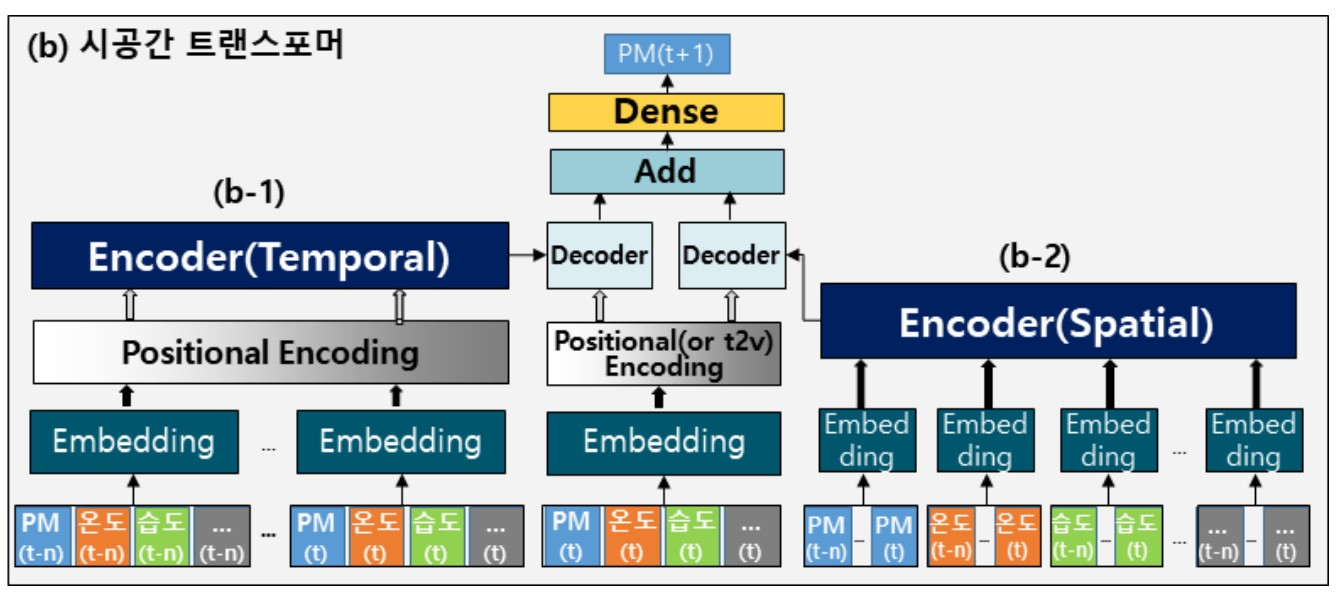

In [ ]:
display(Image(filename='img6.jpg', embed=True))

출처  
http://jalammar.github.io/illustrated-gpt2/  
https://d2l.ai/chapter_recurrent-modern/seq2seq.html  
https://www.tensorflow.org/tutorials/text/transformer
